# Computational statistics - project

## 0. Data

We use *House Prices* data, loaded as a CSV. We do not remove 'NA' values as they seem to be valid values in some categorical factors (we have manually verified that no actual 'NA' value exists in the training dataset). We also remove the 'Id' column since it's just an index we will never use.

In [116]:
    # Generic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re, warnings
    # Time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
    # ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import mean_squared_error as skl_mse
L_TYP = ['int64', 'float64']

In [2]:
def get_df(f):
    f = os.path.join("compstats", f) if not os.path.isfile(f) else f
    df = pd.read_csv(f, header=0, na_filter=False) # some 'NA' are valid values
    df = df.drop("Id", axis=1) if "Id" in df.columns else df
    return df

In [3]:
df = get_df("train.csv"); print(df.shape)             # training data
ft = [col for col in df if df[col].dtype in L_TYP] # numeric features
ft = ft+['n_LandSlope', 'n_ExterQual', 'n_HeatingQC', 'n_KitchenQual']

(1460, 80)


### Normalization

Before analyzing that data, we will *normalize* it. This would include removing 'NA' values but otherwise we:
* Apply a logarithm on the dependent variable ('SalePrice')
* Turn some categorical factors, that are ordinal, into discrete numericals ('LandSlope', 'ExterQual', 'HeatingQC', 'KitchenQual').

The former is there to avoid a tail in the data, to get the variable closer to a normal distribution. The latter is simply for ease of process further down the line.

In [4]:
def _log(v):
    """Logarithme naturel ('np.log') pour toute valeur >0."""
    try:
        v = np.log(v) if v > 0. else v
    except TypeError:
        try:
            v = float(v)
            v = np.log(v) if v > 0. else v
        except ValueError:
            v = np.nan
    return v
def iter_type(df, l_typ=None):
    """Générateur pour un type de donnée."""
    cols, ctyp = list(df.columns), list(df.dtypes)
    for i, col in enumerate(cols):
        if col not in ft:
        # if not ctyp[i] in ['int64', 'float64']: # only numeric
            continue
        yield col, list(df[col])
def est_ranges(df):
    """Fournit les valeurs pour les colonnes numériques."""
    d = {k:[] for k in ['column', 'min', 'max', 'mean']}
    for col, l_v in iter_type(df, L_TYP):
        d['column'].append(col); d['min'].append(np.min(l_v))
        d['max'].append(np.max(l_v)); d['mean'].append(f"{np.mean(l_v):.01f}")
    return pd.DataFrame(d)
def log_num(df):
    """Applique le logarithme à tous les prix et toutes les surfaces."""
    for col, l_v in iter_type(df):    # variables numériques
        if not ("Area" in col or "SalePrice" in col or col.endswith("SF")):
            continue
        df[col] = df[col].apply(_log); ncol = f"log_{col}"
        df = df.rename(columns={col:ncol})
    return df
def ord_cat(df):
    """Transforme des variables catégoriques en numérique."""
    d = {'Gtl':3, 'Mod':2, 'Sev':1}              # première échelle
    if 'n_LandSlope' not in df.columns:
        df['n_LandSlope'] = [d[k] for k in df['LandSlope']]; df = df.drop('LandSlope', axis=1)
    d = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5} # seconde échelle
    for col in ['ExterQual', 'HeatingQC', 'KitchenQual']:
        ncol = f"n_{col}"
        if ncol not in df:
            df[ncol] = [d[k] for k in df[col]]; df = df.drop(col, axis=1)
    return df

In [5]:
df['SalePrice'] = np.log(df['SalePrice'])
df = log_num(df)    # applique le logarithme
df = ord_cat(df)    # transforme en variable numérique

## 1. Time series

While this is the last step we tackled, it comes first when analyzing data. We check whether our data is a time series and if so, we check if there is a trend/seasonality (and variance, changes, etc.). This requires having a single datapoint at every time step. So we:
* Aggregate datapoints for every month.
* Check the ACF / PACF to see what model to apply, if any.

When aggregating, we average the values. In the case of categorical variables, we use dummies. Here we already selected factors for a classic linear regression model and therefore know what categoricals to keep (basically those we turned to numericals, plus 'Neighborhood'). This may lead us to miss relevant factors but we'll accept this weakness. 

### Grouping

Here we:
* Turn the two columns 'YrSold/MoSold' into a 'date' column.
(We also turn 'Neighborhood' into dummy columns.)
* Split our dataset in two.
(Since we aggregate, we still obtain roughly as many points (~50-55) for each.)
* Aggregate the datapoints.

The result is two time series, one for training, one for testing. They should maintain the same columns thoughout the rest of the pipeline for obvious reasons.

In [6]:
def time_col(df):
    """Adds a 'date' column and sorts."""
        # get a 'date' column in datetime
    df['date'] = (df['YrSold']-2006)*12+(df['MoSold']-1)
    df.drop(['YrSold', 'MoSold'], axis=1)
    start_date = pd.Timestamp('2006-01-01')
    df['date'] = [start_date + pd.DateOffset(months=int(m)) for m in df['date']]
        # sort by 'date'
    df = df.sort_values('date')
        # already turn 'neighborhood' into dummies
    df_dummies = pd.get_dummies(df['Neighborhood'])
    df = pd.concat([df, df_dummies], axis=1)
    return df
def _filldf(df, ndf, l_ind, s, e):
    """Fills 'ndf' rows using 'l_ind' indices of 'df'."""
    for i in range(s, e):
        for k in ndf:
            ndf[k].append(df.at[l_ind[i], k])
    return ndf
def train_test_splt(df):
    """Splits training/testing before aggregation."""
    df_tr = {k:[] for k in df.columns.values}
    df_te = df_tr.copy()
    l_ind = [i for i in range(len(df))]; np.random.shuffle(l_ind)
    df_tr = _filldf(df, df_tr, l_ind, 0, len(df)//2)
    df_te = _filldf(df, df_te, l_ind, len(df)//2, len(df))
    return pd.DataFrame(df_tr), pd.DataFrame(df_te)
def _grpbydict(df):
    """Prepares the aggregation dictionary."""
    d_agg = {k:'mean' for k in ft if k in df}
    d_agg['date'] = 'mean'
    if 'log_SalePrice' in df:
        d_agg['log_SalePrice'] = 'mean'
    dumcol = df['Neighborhood'].unique()
    for col in dumcol:
        d_agg[col] = 'mean'
    return d_agg
def aggregate(df):
    """Aggregates dataframe into a time series."""
    return df.groupby("date").agg(_grpbydict(df))

In [7]:
time_df = time_col(df)
neighs = list(time_df['Neighborhood'].unique())
df_tr, df_te = train_test_splt(time_df)
df_tr, df_te = aggregate(df_tr), aggregate(df_te)

### P/ACF

Once we obtain our time series, we plot an ACF and PACF (as well as the difference over time) on the training set.

Here they seem to show no trend/seasonality, so we also check with 'seasonal_decompose'. We can notice that that plot will return a seasonality for several periods (2, 3, 4, 8, 12, etc.). While we expect *House Prices* to follow an annual seasonality (12), looking at the ACF/PACF we notice one point that is barely significant: so while testing (12), we'll assume that our actual seasonality is 4.

In [8]:
def _pltpacf(x, lags, ax, fpacf, title):
    """Repeated part of 'plt_pacf'."""
    fpacf(x, lags=lags, alpha=0.05, ax=ax, zero=False)
    ax.set_title(title, fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
def plt_pacf(df, col="sim", lags=20):
    """Assume a DataFrame, plots P/ACF."""
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    x = df[col]; lx = int(len(x)/2)   # get column (Series)
    lags = lx if lags > lx else lags  # maximum allowed lag
    ax[0].plot(df_tr['date'], x.diff())
    ax[0].set_title("Difference")
    _pltpacf(x, lags, ax[1], plot_acf, "ACF")
    _pltpacf(x, lags, ax[2], plot_pacf, "PACF")
    plt.tight_layout()
    plt.show()

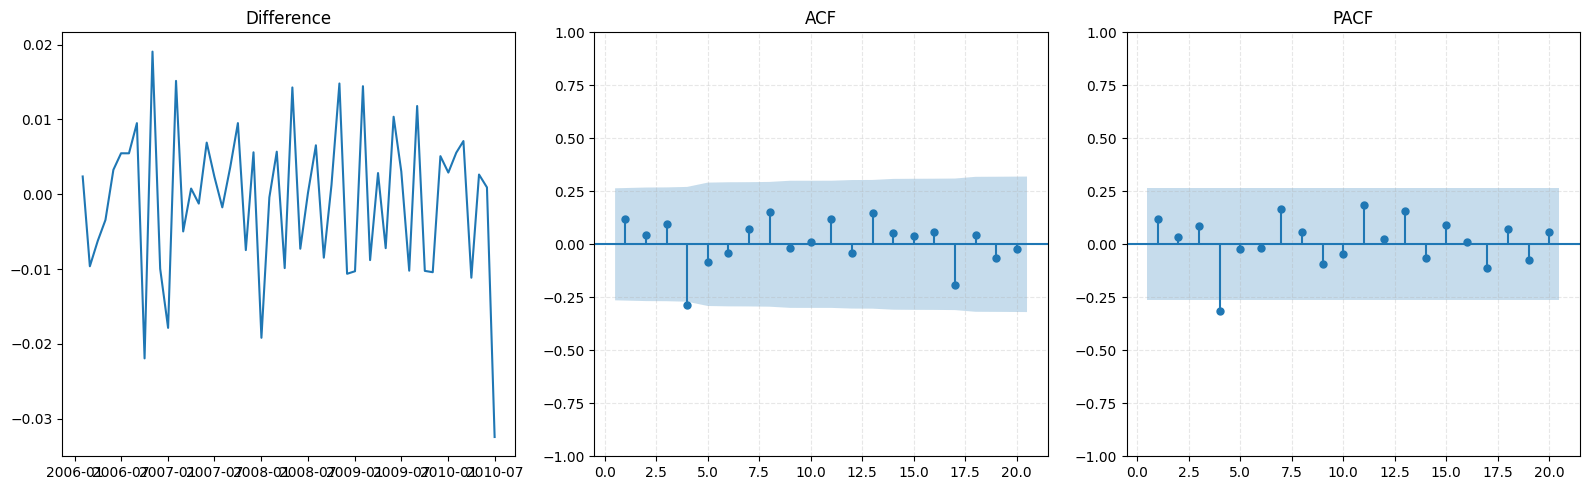

In [9]:
plt_pacf(df_tr, col="log_SalePrice")

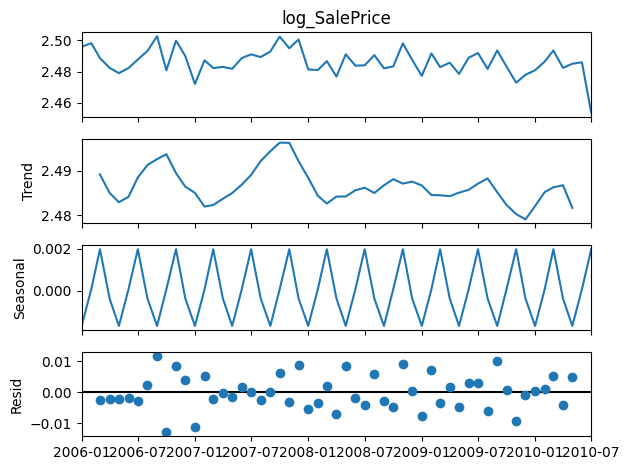

In [10]:
result = seasonal_decompose(df_tr['log_SalePrice'], model="additive", period=4)
result.plot(); a = 12

## 2. Factor selection

We now have our time series and ~confirmed a seasonality of 4. What's left to do is to define the exogenous variables: the factors of a traditional linear regression.

We do that in two steps:
* A simple visualization
* A k-factorial

The visualization shows us what factors have a relation with our dependent variable (and what type of relation). This is purely visual and we (need to) confirm it with hypothesis tests. Once we selected our factors that way, we further confirm them and select their interactions through a k-factorial. We choose not to check factors correlations: this would be done to either further reduce the number of factors or in case of multicolinearity in our results.

### Visualization

In [11]:
def plot_rel(df, figsize=(20, 30)):
    """Visalise relations directes avec 'y'."""
    cols = df.columns.values
    gr = int(np.ceil(len(cols)/5))
    fig, ax = plt.subplots(gr, 5, figsize=figsize)
    for i, col in enumerate(cols):
        if col == "date":
            continue
        r, c = int(np.floor(i/5)), i%5
        ax[r, c].scatter(df[col], df['log_SalePrice'])
        ax[r, c].set_xlabel(col); ax[r, c].set_ylabel('log_SalePrice')
    fig.tight_layout()
    fig.show()

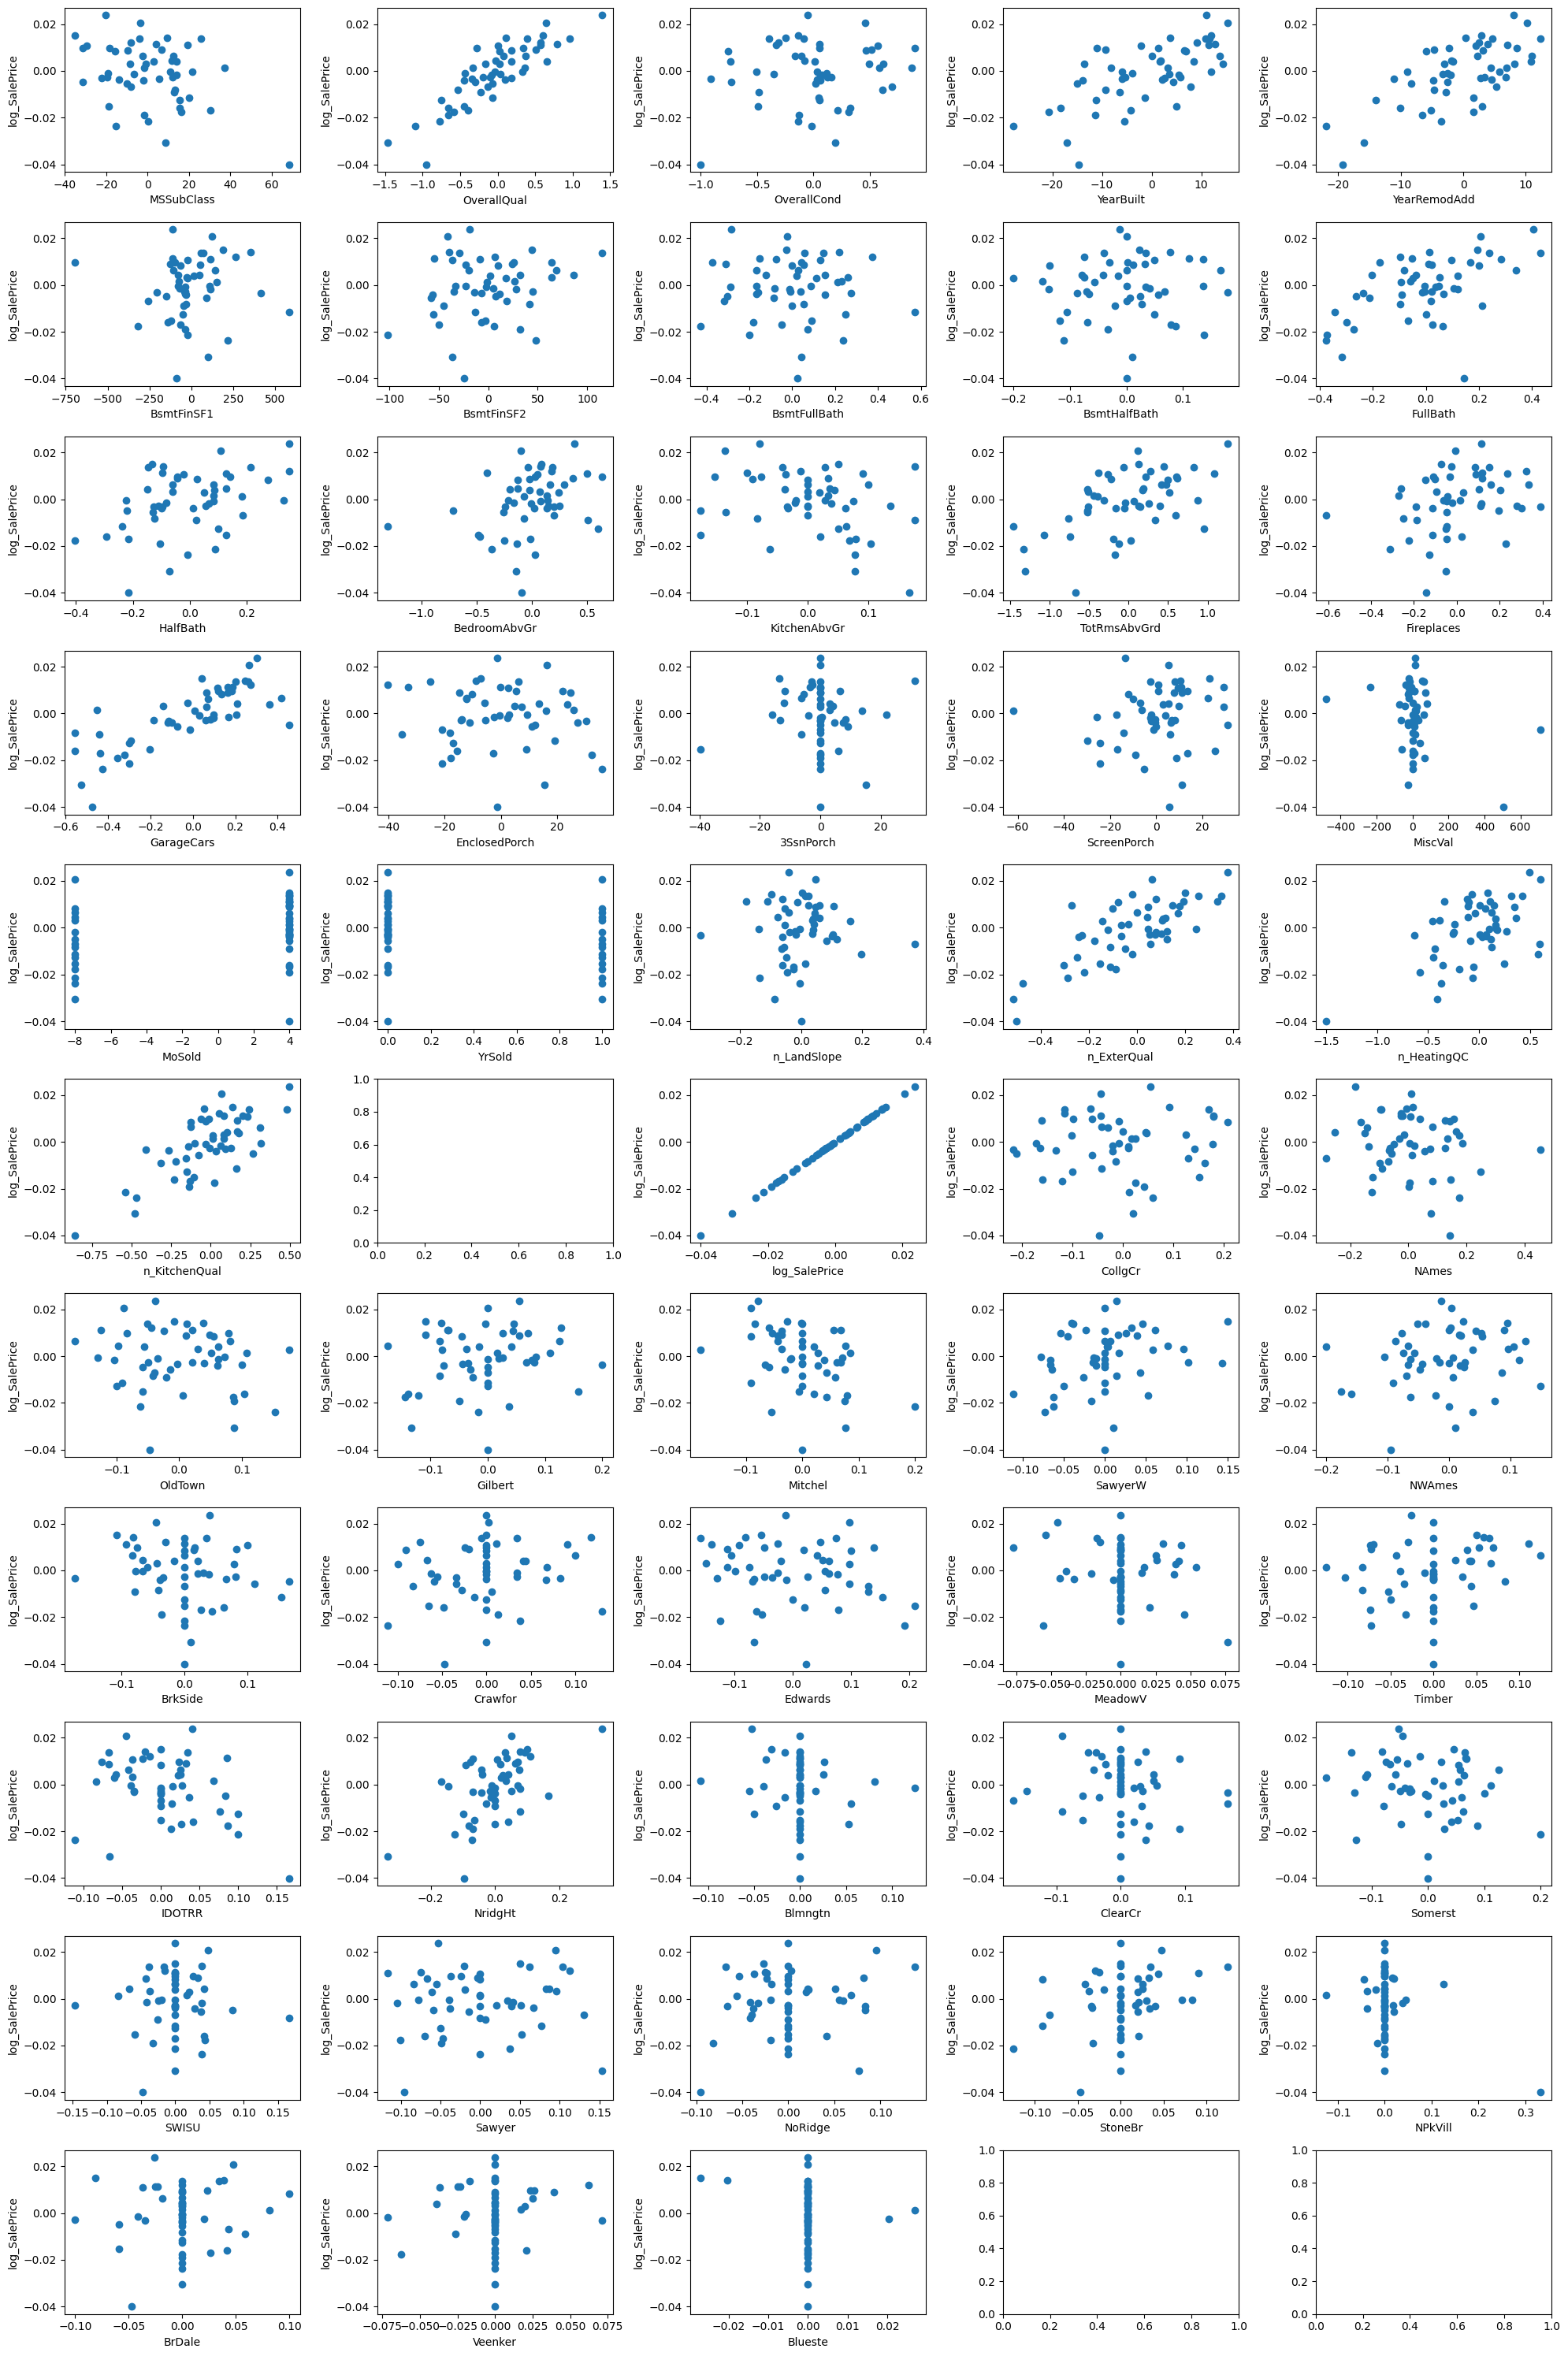

In [12]:
df_shtr = (df_tr - df_tr.shift(4)).dropna() # Assume a period of 4
plot_rel(df_shtr)

### k-factorial

Our number of datapoints (~50-55) limits the size of our factorial: we can't go above 2^5. We however have a half-dozen candidates. Eventually, though, and by manually testing combinations of factors, we can ignore those that fail the F-test. 

The output, filtered by p-value at 95% confidence, is all the factors (and interactions) used as exogenous variables for our model.

In [13]:
def prep_k(df, factors, y):
    """Creates a sub-DataFrame for ANOVA."""
    df_sub = df[[y]+factors].copy()                             # subset
    df_sub = df_sub.reset_index(drop=True)                      # indices are integers
    for k in factors:
        km = np.median(df_sub[k])                               # get the median
        df_sub[k] = np.where(df_sub[k] < km, 'low', 'high')     # reduce to 2 values
        df_sub[k] = df_sub[k].astype('category')                # (optional) set dtype
    return df_sub
def k_fact(df, factors, y, pval=0.05):
    """Run ANOVA on a linear regression model."""
    m = ols(f'{y} ~ ' + ' * '.join(factors), data=df).fit()
    res = anova_lm(m)
    if pval > 0.:
        res = res[res['PR(>F)'] < pval]
    return res

In [14]:
factors, y=['OverallQual', 'GarageCars', 'n_ExterQual'], "log_SalePrice"
df_subtr = prep_k(df_shtr, factors, y)
res = k_fact(df_subtr, factors, y, pval=0.05)
print(res)

                         df    sum_sq   mean_sq          F        PR(>F)
OverallQual             1.0  0.004237  0.004237  61.215272  8.427913e-10
GarageCars              1.0  0.000686  0.000686   9.911615  2.982950e-03
GarageCars:n_ExterQual  1.0  0.000341  0.000341   4.920258  3.187547e-02


In [15]:
df_tr['Garage*Exter'] = df_tr['GarageCars']*df_tr['n_ExterQual']
df_te['Garage*Exter'] = df_te['GarageCars']*df_te['n_ExterQual']

## 3. Model

Since our data turns out to be a time series with exogenous variables, we default to a SARIMAX model.

We still aren't sure of our model (seasonal parameters, etc.) and so what we do is loop over every combination possible and keep the one with the lowest AIC value. However:
* We must also take into account if all coefficients are significant. If not, we should eliminate the model.
* We likewise want a model that covers all trend/seasonality. Therefore we also track the Jarque-Bera test during the loop.

What remains is to check the residuals for normality, and use our test dataset to get an accuracy score.

### SARIMAX

A SARIMAX requires:
1. Parameters for a lag-1 model (ARIMA)
2. Parameters for a lag-x model (SARIMA)
3. Exogenous variables (SARIMAX)

We only keep the lowest AIC model but print as much information about it during the process for comparison.

The result is a SARIMA(0,0,0)*(0,1,1,4) that confirms a lag-4 time series. It also excludes the interaction suggested by our k-factorial.

In [98]:
def _itsarimax(factors, orders, s_orders):
    """Generator for SARIMAX."""
    for factor in factors:
        for order in orders:
            for s_order in s_orders:
                yield factor, order, s_order
def jarque_bera(mf):
    """Get Jarque-Bera statistics (and p-value)."""
    smr = str(mf.summary()).split("Jarque-Bera",1)[1]
    jb_stat, _, jb_pval = smr.split(":",3)[1:]
    jb_stat = float(jb_stat.split("\n",1)[0].strip())
    jb_pval = float(jb_pval.split("\n",1)[0].strip())
    return jb_stat, jb_pval
def pick_SARIMAX(df, y, factors, orders, s_orders):
    """Runs all combinations of SARIMAX and keeps the best."""
    df = df.set_index('date') # ensure 'date' is the index
    df = df.asfreq('MS')      # set that as frequency
    gm, gaic = None, np.inf
    for factor, order, s_order in _itsarimax(factors, orders, s_orders):
        print(">", factors, order, s_order, end=" "*40+"\r")
        df_ex = df[factor] # exogenous variables
        ch_uw = 'None'     # UserWarning check
        m = SARIMAX(df[y], order=order,
                    seasonal_order=s_order,
                    exog=df_ex)
        with warnings.catch_warnings():
            warnings.simplefilter("error", UserWarning)
            warnings.simplefilter("error", ConvergenceWarning)
            try:
                mf = m.fit(disp=False)
            except UserWarning:        # be careful
                ch_uw = 'Alert'
            except ConvergenceWarning: # failed, discard
                continue
        ch_coeff = all(mf.pvalues < 0.05)
        jb_stat, jb_pval = jarque_bera(mf)
        if jb_pval < 0.05:
            print("JB p<0.05:", factor, order, s_order, jb_stat, jb_pval)
            print(mf.summary())
        if mf.aic < gaic:
            gm, gaic = mf, mf.aic
            print(f"New best: {factor}, {order}, {s_order}, AIC: {mf.aic}"+
                  f", coeffs: {ch_coeff}, UserWarning: {ch_uw}, Jarque_Bera: {jb_stat}|{jb_pval}.")
    print("\r"+" "*100+"\r")
    return gm

In [99]:
factors = [
    # ['OverallQual', 'GarageCars', 'Garage*Exter'],
    ['OverallQual', 'GarageCars'],
    # ['OverallQual'],
    # ['GarageCars']
]
orders = [
    (1, 0, 0),
    (1, 0, 1),
    (0, 0, 1),
    (0, 0, 0)
]
s_orders = [
    (1, 1, 0, 4),
    (0, 1, 1, 4),
    (0, 1, 0, 4),
    (1, 1, 1, 4),
    (1, 0, 1, 4),
    (1, 0, 0, 4),
    (0, 0, 1, 4),
    (1, 1, 0, 12),
    (0, 1, 1, 12),
    (0, 1, 0, 12),
    (1, 1, 1, 12),
    (1, 0, 1, 12),
    (1, 0, 0, 12),
    (0, 0, 1, 12),
    (0, 0, 0, 4)
]

In [97]:
m_sarimax = pick_SARIMAX(df_tr, y, factors, orders, s_orders)

New best: ['OverallQual', 'GarageCars'], (1, 0, 0), (1, 1, 0, 4), AIC: -380.2217973143869, coeffs: False, UserWarning: None, Jarque_Bera: 0.79.
New best: ['OverallQual', 'GarageCars'], (1, 0, 1), (0, 1, 1, 4), AIC: -385.95099780811677, coeffs: False, UserWarning: None, Jarque_Bera: 0.12.
New best: ['OverallQual', 'GarageCars'], (0, 0, 1), (0, 1, 1, 4), AIC: -387.95391542443264, coeffs: False, UserWarning: None, Jarque_Bera: 0.13.
New best: ['OverallQual', 'GarageCars'], (0, 0, 0), (0, 1, 1, 4), AIC: -389.9568933021945, coeffs: True, UserWarning: None, Jarque_Bera: 0.12.
                                                                                                    


In [23]:
m_sarimax.summary() # Kurtosis should be at ~3.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:             log_SalePrice   No. Observations:                   55
Model:             SARIMAX(0, 1, [1], 4)   Log Likelihood                 198.978
Date:                   Sat, 24 May 2025   AIC                           -389.957
Time:                           10:38:30   BIC                           -382.230
Sample:                       01-01-2006   HQIC                          -387.004
                            - 07-01-2010                                         
Covariance Type:                     opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
OverallQual     0.0143      0.003      5.085      0.000       0.009       0.020
GarageCars      0.0162      0.005      3.550      0.000       0.007       0.025
ma.S.L4        -0.8114      0.224     -3.626      0.000      -1.250      -0.373
sigma2       2.194e-05   4.44e-06      4.937      0.000    1.32e-05    3.07e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.17
Prob(Q):                              0.95   Prob(JB):                         0.12
Heteroskedasticity (H):               1.54   Skew:                            -0.44
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuals

Even before considering the residuals, we observe a Jarque-Bera test > 4., as well as a Kurtosis of 4. That kurtosis should be at ~3.. Conversely, Ljung-Box suggests that our auto-correlation causes no problem. This is what we will check here by:
* Plotting the residuals over time
* Plotting their histogram
* Using a QQ Plot
* Plotting ACF / PACF

All show that the residuals follow a normal distribution, without any auto-regression left. What kurtosis remains can be attributed solely to exogenous variables.

In [110]:
def check_resid(model):
    """Check model residuals."""
    fig, ax = plt.subplots(2, 3, figsize=(12,8))
    resid = model.resid[4:] # Kalman filter warm-up TAMER
    ax[0, 0].plot(resid)
    ax[0, 0].set_title('Residuals')
    ax[0, 0].set_xlabel('date'); ax[0, 0].set_ylabel('Residual')
    resid.plot(kind='hist', bins=30, density=True, alpha=0.5, ax=ax[0, 1])
    resid.plot(kind='kde', ax=ax[0, 1])
    sm.qqplot(resid, line='s', ax=ax[0, 2])
    ax[0, 2].set_title('QQ Plot')
    ax[0, 1].set_title('Histogram/Density')
    plot_acf(resid, ax=ax[1, 0], lags=20, zero=False)
    ax[1, 0].set_title('ACF')
    plot_pacf(resid, ax=ax[1, 1], lags=20, zero=False)
    ax[1, 1].set_title('PACF')
    fig.delaxes(ax[1, 2])
    plt.tight_layout()
    plt.show()

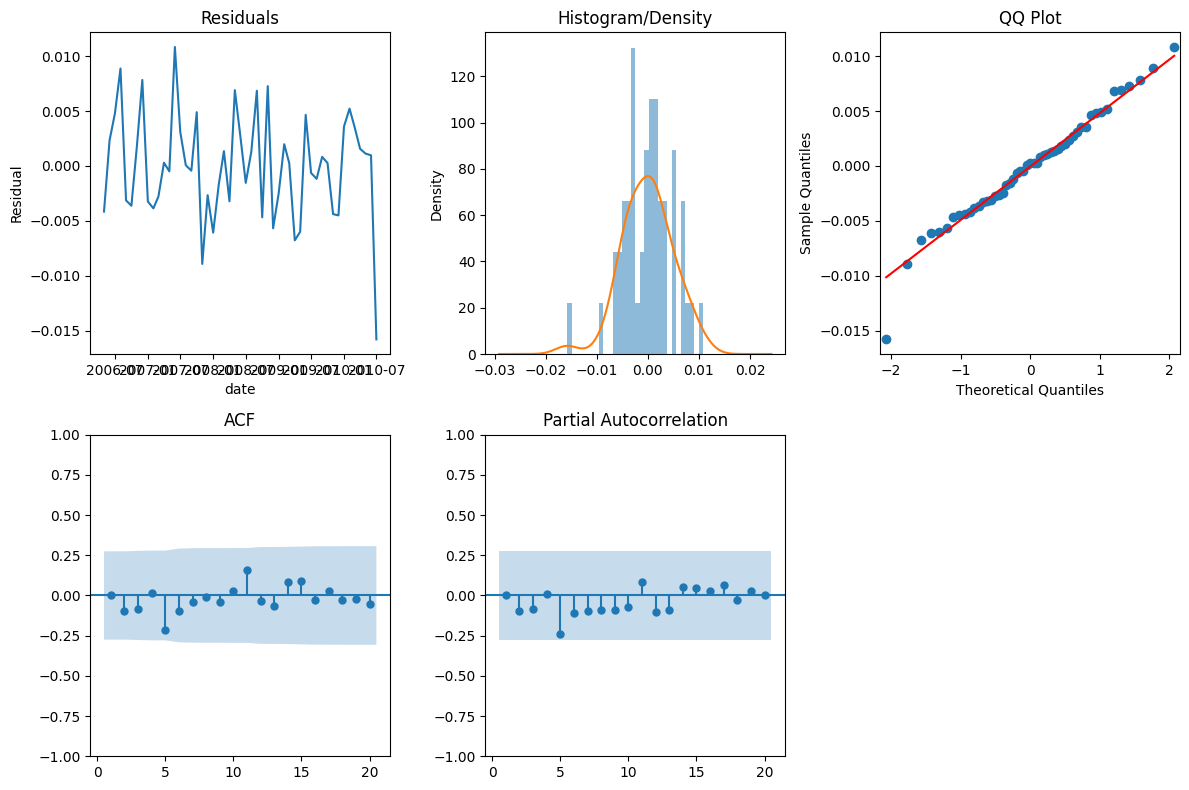

In [111]:
check_resid(m_sarimax)

### Accuracy

Finally, we can test our model on the training data we had kept, by predicting values and comparing with a Mean Square Error. Here the result is < 0.001.

In [118]:
factor = ['OverallQual', 'GarageCars']
df_subte = df_te[factor]
y_pred = m_sarimax.forecast(steps=len(df_subte), exog=df_subte)
print("MSE:", skl_mse(df_te[y], y_pred))

MSE: 2.1380559022555865e-05
